# XAI (SHAP+XGBoost) vs CI (LiNGAM): 擬似相関の識別能力比較レポート

**目的**: 機械学習の説明手法 (SHAP) と因果探索手法 (LiNGAM) が、
擬似相関をどの程度正しく識別できるかを、医療ドメインの合成データで検証する。

**結論 (先出し)**:
- SHAP は擬似相関変数にも高い重要度を付与し、**真の原因と区別できない**
- LiNGAM は因果グラフを推定し、擬似相関変数を Outcome の直接原因から **正しく除外** できる
- 意思決定には因果推論の併用が不可欠

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Meiryo'
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12

# データ読み込み
df = pd.read_csv('../dataset_valid.csv')

# 真の因果構造メタデータ
DIRECT_CAUSES = ['Treatment', 'Severity', 'Age', 'DrugB']
SPURIOUS_CORR = ['BP_reading', 'Lab_marker', 'Nurse_score']
INDEPENDENT   = ['Room_num', 'Day_of_week']
UPSTREAM      = ['Genetics', 'Lifestyle', 'Region', 'Insurance']
TARGET = 'Outcome'
features = [c for c in df.columns if c != TARGET]

# カテゴリ色定義
CAT_COLORS = {
    '直接原因': '#1976D2',
    '擬似相関': '#D32F2F',
    '独立ノイズ': '#757575',
    '上流変数': '#F57C00',
}

def get_category(feat):
    if feat in DIRECT_CAUSES: return '直接原因'
    if feat in SPURIOUS_CORR: return '擬似相関'
    if feat in INDEPENDENT: return '独立ノイズ'
    return '上流変数'

def get_color(feat):
    return CAT_COLORS[get_category(feat)]

print(f'データサイズ: {df.shape[0]:,} 行 × {df.shape[1]} 列')
print(f'目的変数: {TARGET}')
print(f'直接原因 ({len(DIRECT_CAUSES)}): {DIRECT_CAUSES}')
print(f'擬似相関 ({len(SPURIOUS_CORR)}): {SPURIOUS_CORR}')

データサイズ: 1,500 行 × 14 列
目的変数: Outcome
直接原因 (4): ['Treatment', 'Severity', 'Age', 'DrugB']
擬似相関 (3): ['BP_reading', 'Lab_marker', 'Nurse_score']


---
## 1. 真の因果構造 (DAG)

このデータは既知の因果グラフから生成されています。  
Outcome に**直接的に**影響する変数は **Treatment, Severity, Age, DrugB** の 4 つだけです。  
BP_reading, Lab_marker, Nurse_score は直接原因の「子ノード」であり、Outcome と**相関はあるが因果効果はありません**。

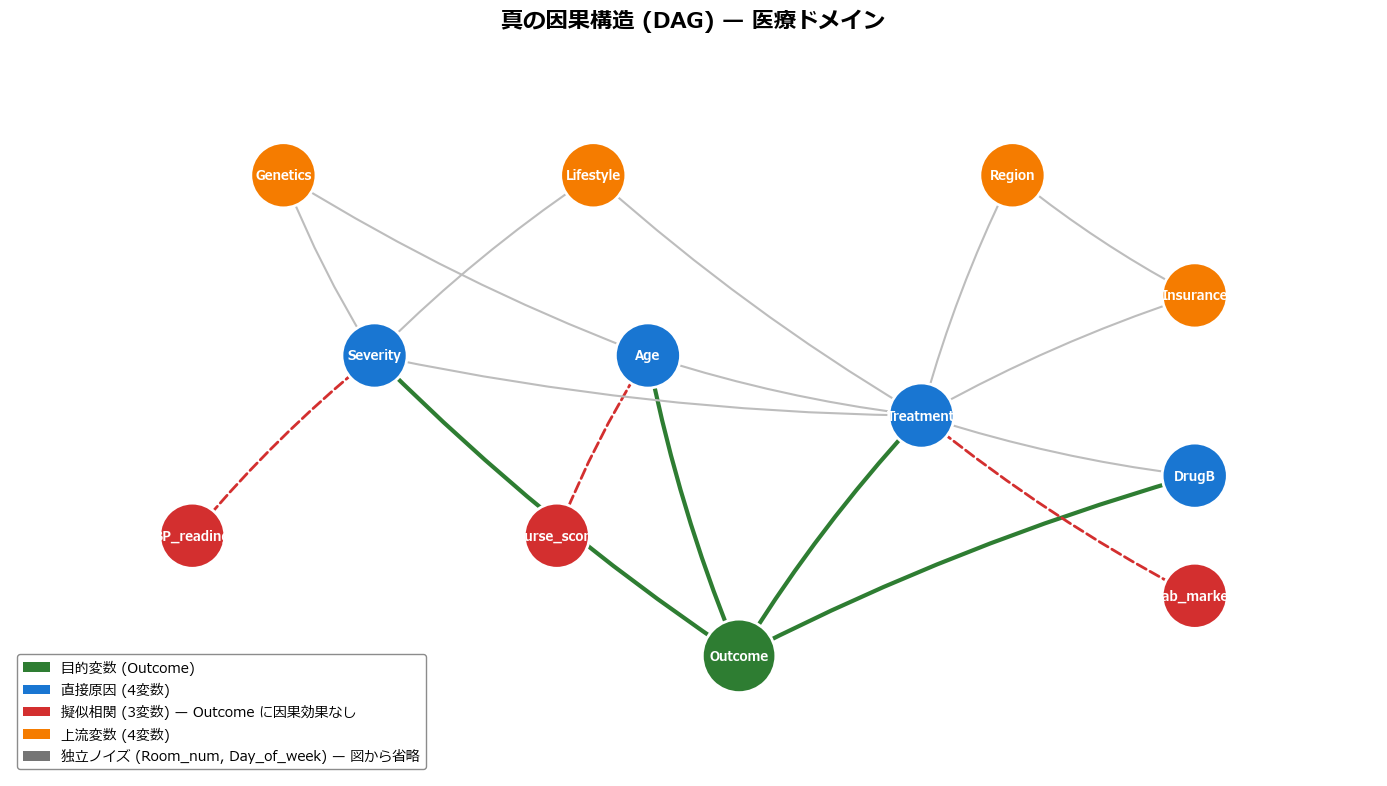

In [2]:
import networkx as nx

# 真の因果構造を定義
true_edges = [
    ('Genetics', 'Severity'), ('Genetics', 'Age'),
    ('Lifestyle', 'Severity'), ('Lifestyle', 'Treatment'),
    ('Region', 'Insurance'), ('Region', 'Treatment'),
    ('Insurance', 'Treatment'),
    ('Severity', 'Treatment'), ('Severity', 'Outcome'), ('Severity', 'BP_reading'),
    ('Age', 'Treatment'), ('Age', 'Outcome'), ('Age', 'Nurse_score'),
    ('Treatment', 'DrugB'), ('Treatment', 'Outcome'), ('Treatment', 'Lab_marker'),
    ('DrugB', 'Outcome'),
]

G = nx.DiGraph(true_edges)

# レイアウトを手動設定 (見やすさ重視)
pos = {
    'Genetics':   (-2.5, 3),
    'Lifestyle':  (-0.8, 3),
    'Region':     (1.5, 3),
    'Insurance':  (2.5, 2),
    'Severity':   (-2, 1.5),
    'Age':        (-0.5, 1.5),
    'Treatment':  (1, 1),
    'DrugB':      (2.5, 0.5),
    'BP_reading': (-3, 0),
    'Nurse_score':(-1, 0),
    'Lab_marker': (2.5, -0.5),
    'Outcome':    (0, -1),
}

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_title('真の因果構造 (DAG) — 医療ドメイン', fontsize=16, fontweight='bold', pad=20)

node_colors = [get_color(n) if n != TARGET else '#2E7D32' for n in G.nodes()]
node_sizes = [2800 if n == TARGET else 2200 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors,
                       node_size=node_sizes, edgecolors='white', linewidths=2)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=9, font_family='Meiryo',
                        font_color='white', font_weight='bold')

# エッジを描画 (Outcome への直接エッジは太く)
direct_edges = [(u, v) for u, v in true_edges if v == TARGET]
other_edges  = [(u, v) for u, v in true_edges if v != TARGET]
spurious_edges = [(u, v) for u, v in true_edges if v in SPURIOUS_CORR]
struct_edges = [(u, v) for u, v in other_edges if v not in SPURIOUS_CORR]

nx.draw_networkx_edges(G, pos, edgelist=direct_edges, ax=ax,
                       edge_color='#2E7D32', width=3, arrows=True,
                       arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.05')
nx.draw_networkx_edges(G, pos, edgelist=spurious_edges, ax=ax,
                       edge_color='#D32F2F', width=2, style='dashed', arrows=True,
                       arrowsize=15, arrowstyle='->', connectionstyle='arc3,rad=0.05')
nx.draw_networkx_edges(G, pos, edgelist=struct_edges, ax=ax,
                       edge_color='#BDBDBD', width=1.5, arrows=True,
                       arrowsize=12, arrowstyle='->', connectionstyle='arc3,rad=0.05')

# 凡例
legend_elements = [
    mpatches.Patch(facecolor='#2E7D32', label='目的変数 (Outcome)'),
    mpatches.Patch(facecolor=CAT_COLORS['直接原因'], label='直接原因 (4変数)'),
    mpatches.Patch(facecolor=CAT_COLORS['擬似相関'], label='擬似相関 (3変数) — Outcome に因果効果なし'),
    mpatches.Patch(facecolor=CAT_COLORS['上流変数'], label='上流変数 (4変数)'),
    mpatches.Patch(facecolor=CAT_COLORS['独立ノイズ'], label='独立ノイズ (Room_num, Day_of_week) — 図から省略'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10,
          framealpha=0.9, edgecolor='gray')

ax.set_xlim(-4, 3.5)
ax.set_ylim(-2, 4)
ax.axis('off')
plt.tight_layout()
plt.show()

---
## 2. SHAP 分析: XGBoost の「特徴量重要度」

XGBoost を学習し、SHAP (TreeExplainer) で各特徴量の予測貢献度を算出します。  
**注意**: SHAP は「予測に役立つか」を測定し、「因果効果があるか」は測定しません。

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import shap

X_all = df[features]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)

xgb = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1,
                   random_state=42, n_jobs=-1, verbosity=0)
xgb.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0), index=features
).sort_values(ascending=False)

print(f'XGBoost R² (test): {xgb.score(X_test, y_test):.4f}')
print(f'\n=== SHAP 特徴量重要度 ===')
for i, (feat, imp) in enumerate(shap_importance.items()):
    tag = ''
    if feat in SPURIOUS_CORR: tag = ' << 擬似相関!'
    elif feat in DIRECT_CAUSES: tag = ' (直接原因)'
    print(f'  {i+1:2d}. {feat:12s}: {imp:.4f}{tag}')

XGBoost R² (test): 0.8494

=== SHAP 特徴量重要度 ===
   1. Treatment   : 0.9440 (直接原因)
   2. DrugB       : 0.5833 (直接原因)
   3. Severity    : 0.3806 (直接原因)
   4. BP_reading  : 0.2238 << 擬似相関!
   5. Age         : 0.0960 (直接原因)
   6. Lab_marker  : 0.0895 << 擬似相関!
   7. Lifestyle   : 0.0852
   8. Room_num    : 0.0646
   9. Genetics    : 0.0629
  10. Nurse_score : 0.0600 << 擬似相関!
  11. Day_of_week : 0.0327
  12. Insurance   : 0.0179
  13. Region      : 0.0108


---
## 3. LiNGAM: 因果構造の推定

LiNGAM (DirectLiNGAM) は、データの**非ガウス性**を利用して因果方向と因果効果の大きさを同時に推定します。  
SHAP とは異なり、「Outcome に直接影響する変数は何か」を構造的に判定します。

| 項目 | SHAP (XAI) | LiNGAM (CI) |
|:---|:---|:---|
| 測定対象 | 予測への貢献度 | 因果効果の大きさ |
| 出力 | 重要度スコア (連続値) | 因果グラフ + 効果量 |
| 擬似相関 | 区別できない | 正しく除外 |

In [4]:
import lingam

columns = list(df.columns)
data = df.values
y_idx = columns.index(TARGET)

print('LiNGAM (DirectLiNGAM) 実行中...')
lingam_model = lingam.DirectLiNGAM()
lingam_model.fit(data)
adj_matrix = lingam_model.adjacency_matrix_

# Outcome への直接因果効果を抽出
lingam_effects = pd.Series(adj_matrix[y_idx, :], index=columns).drop(TARGET)
lingam_threshold = 0.1  # |因果効果| > 0.1 を「直接原因」と判定
lingam_adjacent = [f for f in features if abs(lingam_effects[f]) > lingam_threshold]

# 因果効果を絶対値で降順ソート
lingam_sorted = lingam_effects.abs().sort_values(ascending=False)

print(f'\n=== LiNGAM: Outcome への因果効果 ===')
for i, feat in enumerate(lingam_sorted.index):
    eff = lingam_effects[feat]
    tag = ''
    if feat in SPURIOUS_CORR: tag = ' << 擬似相関 (正しく≈0)'
    elif feat in DIRECT_CAUSES: tag = ' (直接原因)'
    marker = '***' if abs(eff) > lingam_threshold else '   '
    print(f'  {marker} {feat:12s}: {eff:+.4f}{tag}')

print(f'\n直接原因と判定 (|効果|>{lingam_threshold}): {sorted(lingam_adjacent)}')
print(f'真の直接原因: {DIRECT_CAUSES}')

LiNGAM (DirectLiNGAM) 実行中...



=== LiNGAM: Outcome への因果効果 ===
  *** Severity    : +0.8889 (直接原因)
  *** DrugB       : +0.7315 (直接原因)
  *** Treatment   : +0.5872 (直接原因)
      Age         : +0.0130 (直接原因)
      Genetics    : +0.0000
      Insurance   : +0.0000
      Region      : +0.0000
      Lifestyle   : +0.0000
      BP_reading  : +0.0000 << 擬似相関 (正しく≈0)
      Lab_marker  : +0.0000 << 擬似相関 (正しく≈0)
      Nurse_score : +0.0000 << 擬似相関 (正しく≈0)
      Room_num    : +0.0000
      Day_of_week : +0.0000

直接原因と判定 (|効果|>0.1): ['DrugB', 'Severity', 'Treatment']
真の直接原因: ['Treatment', 'Severity', 'Age', 'DrugB']


---
## 4. 核心比較: 擬似相関の検知能力

### 4-1. SHAP 重要度 vs LiNGAM 因果効果 — 左右対比パネル

同じ変数を左右に並べて、SHAP と LiNGAM の評価を直接比較します。  
**赤の帯** = 擬似相関変数。SHAP では上位にランクインするが、LiNGAM では因果効果 ≈ 0 と正しく判定されます。

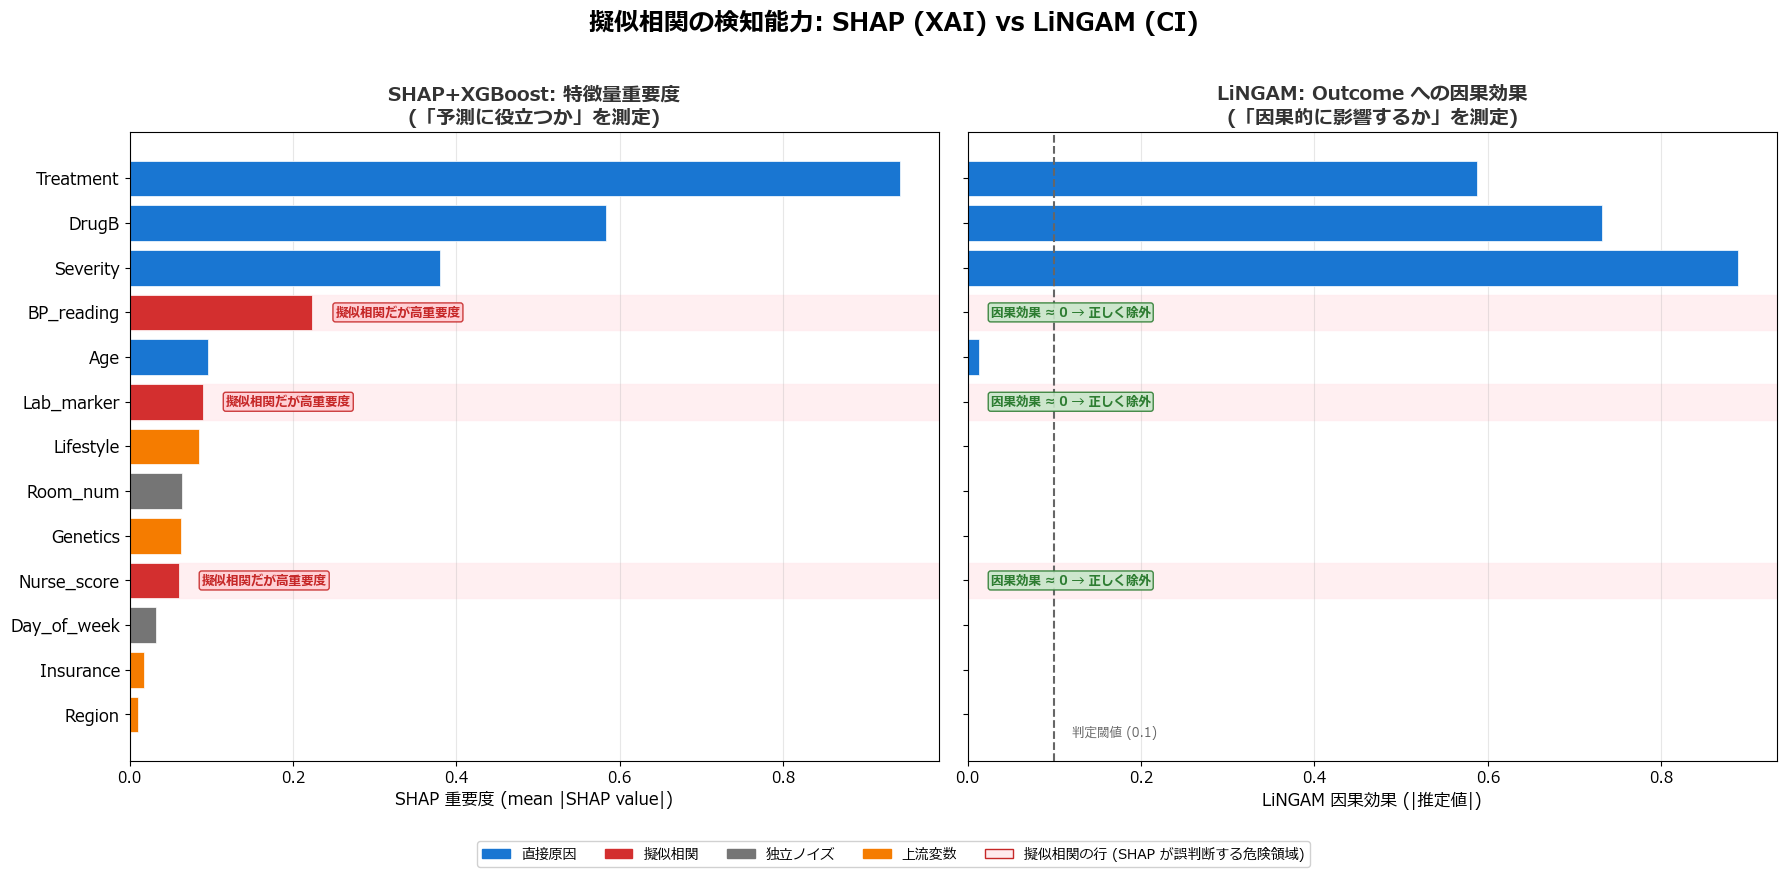

【左】SHAP: 擬似相関変数 (赤) が直接原因と混在 → 区別できない
【右】LiNGAM: 擬似相関変数の因果効果 ≈ 0 → 明確に区別可能


In [5]:
# SHAP重要度の降順で変数を並べる
ordered_feats = shap_importance.index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
fig.suptitle('擬似相関の検知能力: SHAP (XAI) vs LiNGAM (CI)',
             fontsize=18, fontweight='bold', y=1.02)

y_pos = np.arange(len(ordered_feats))

# --- 擬似相関の行に赤背景帯 ---
for ax in [ax1, ax2]:
    for i, feat in enumerate(ordered_feats):
        if feat in SPURIOUS_CORR:
            ax.axhspan(i - 0.4, i + 0.4, color='#FFEBEE', alpha=0.8, zorder=0)

# --- 左パネル: SHAP 重要度 ---
shap_vals = [shap_importance[f] for f in ordered_feats]
bar_colors = [get_color(f) for f in ordered_feats]

bars1 = ax1.barh(y_pos, shap_vals, color=bar_colors, edgecolor='white', linewidth=0.5, zorder=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(ordered_feats, fontsize=12)
ax1.set_xlabel('SHAP 重要度 (mean |SHAP value|)', fontsize=12)
ax1.set_title('SHAP+XGBoost: 特徴量重要度\n(「予測に役立つか」を測定)',
              fontsize=14, fontweight='bold', color='#333')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, zorder=0)

# 擬似相関変数にラベル
for i, feat in enumerate(ordered_feats):
    if feat in SPURIOUS_CORR:
        ax1.text(shap_importance[feat] + shap_importance.max() * 0.03, i,
                '擬似相関だが高重要度',
                va='center', fontsize=9, fontweight='bold', color='#C62828',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='#FFCDD2',
                         edgecolor='#C62828', alpha=0.9))

# --- 右パネル: LiNGAM 因果効果 ---
lingam_vals = [abs(lingam_effects[f]) for f in ordered_feats]

bars2 = ax2.barh(y_pos, lingam_vals, color=bar_colors, edgecolor='white', linewidth=0.5, zorder=2)
ax2.set_xlabel('LiNGAM 因果効果 (|推定値|)', fontsize=12)
ax2.set_title('LiNGAM: Outcome への因果効果\n(「因果的に影響するか」を測定)',
              fontsize=14, fontweight='bold', color='#333')
ax2.grid(axis='x', alpha=0.3, zorder=0)

# 閾値線
ax2.axvline(x=lingam_threshold, color='#666', linestyle='--', linewidth=1.5, zorder=3)
ax2.text(lingam_threshold + 0.02, len(ordered_feats) - 0.5,
         f'判定閾値 ({lingam_threshold})', fontsize=9, color='#666')

# 擬似相関変数にラベル
for i, feat in enumerate(ordered_feats):
    if feat in SPURIOUS_CORR:
        ax2.text(max(abs(lingam_effects[feat]), 0) + max(lingam_vals) * 0.03, i,
                '因果効果 ≈ 0 → 正しく除外',
                va='center', fontsize=9, fontweight='bold', color='#2E7D32',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='#C8E6C9',
                         edgecolor='#2E7D32', alpha=0.9))

# 共通凡例
legend_handles = [mpatches.Patch(color=c, label=l) for l, c in CAT_COLORS.items()]
legend_handles.append(mpatches.Patch(facecolor='#FFEBEE', edgecolor='#C62828',
                                     label='擬似相関の行 (SHAP が誤判断する危険領域)'))
fig.legend(handles=legend_handles, loc='lower center', ncol=5, fontsize=10,
           bbox_to_anchor=(0.5, -0.06), framealpha=0.9)

plt.tight_layout()
plt.show()

print('【左】SHAP: 擬似相関変数 (赤) が直接原因と混在 → 区別できない')
print('【右】LiNGAM: 擬似相関変数の因果効果 ≈ 0 → 明確に区別可能')

### 4-2. 判定結果マトリクス

各変数について「Outcome の直接原因か否か」の判定結果を比較します。
- **SHAP**: 重要度が中央値以上 → 「重要」と判定
- **LiNGAM**: |因果効果| > 0.1 → 「直接原因」と判定

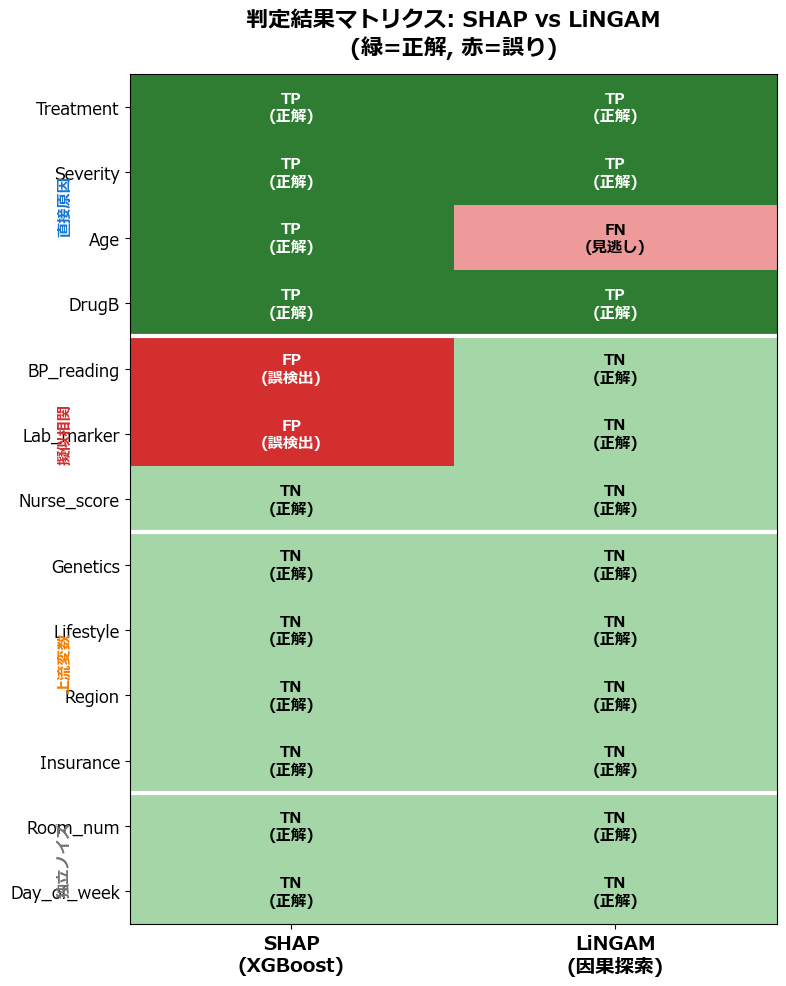

=== 正解率サマリ ===
  SHAP   : 正解率=85%  Precision=67%  Recall=100%  (TP=4, TN=7, FP=2, FN=0)
  LiNGAM : 正解率=92%  Precision=100%  Recall=75%  (TP=3, TN=9, FP=0, FN=1)


In [6]:
from matplotlib.colors import ListedColormap

shap_threshold = shap_importance.median()

results = []
for feat in features:
    is_true = feat in DIRECT_CAUSES
    shap_pos = shap_importance[feat] > shap_threshold
    lingam_pos = feat in lingam_adjacent

    def verdict(pred, truth):
        if truth and pred:     return '正解 (TP)'
        if truth and not pred: return '見逃し (FN)'
        if not truth and pred: return '誤検出 (FP)'
        return '正解 (TN)'

    results.append({
        '変数': feat,
        'カテゴリ': get_category(feat),
        'SHAP判定':   verdict(shap_pos, is_true),
        'LiNGAM判定': verdict(lingam_pos, is_true),
    })

verdict_map = {'正解 (TP)': 2, '正解 (TN)': 1, '見逃し (FN)': -1, '誤検出 (FP)': -2}

heatmap_data = pd.DataFrame({
    'SHAP\n(XGBoost)': [verdict_map[r['SHAP判定']]   for r in results],
    'LiNGAM\n(因果探索)':  [verdict_map[r['LiNGAM判定']] for r in results],
}, index=[r['変数'] for r in results])

# ソート: 直接原因 → 擬似相関 → 上流 → 独立ノイズ
sort_order = {f: i for i, f in enumerate(DIRECT_CAUSES + SPURIOUS_CORR + UPSTREAM + INDEPENDENT)}
heatmap_data = heatmap_data.loc[sorted(heatmap_data.index, key=lambda x: sort_order.get(x, 99))]

fig, ax = plt.subplots(figsize=(8, 10))

cmap = ListedColormap(['#D32F2F', '#EF9A9A', '#A5D6A7', '#2E7D32'])
bounds = [-2.5, -1.5, -0.5, 1.5, 2.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(heatmap_data.values, cmap=cmap, norm=norm, aspect='auto')

ax.set_xticks([0, 1])
ax.set_xticklabels(heatmap_data.columns, fontsize=14, fontweight='bold')
ax.set_yticks(range(len(heatmap_data)))
ax.set_yticklabels(heatmap_data.index, fontsize=12)

label_map = {2: 'TP\n(正解)', 1: 'TN\n(正解)', -1: 'FN\n(見逃し)', -2: 'FP\n(誤検出)'}
for i in range(len(heatmap_data)):
    for j in range(2):
        val = heatmap_data.values[i, j]
        text_color = 'white' if abs(val) == 2 else 'black'
        ax.text(j, i, label_map[val], ha='center', va='center',
               fontsize=11, fontweight='bold', color=text_color)

# カテゴリ区切り線
for y_line in [len(DIRECT_CAUSES) - 0.5,
               len(DIRECT_CAUSES) + len(SPURIOUS_CORR) - 0.5,
               len(DIRECT_CAUSES) + len(SPURIOUS_CORR) + len(UPSTREAM) - 0.5]:
    ax.axhline(y=y_line, color='white', linewidth=3)

# カテゴリラベル
cat_positions = [
    (len(DIRECT_CAUSES)/2 - 0.5, '直接原因', '#1976D2'),
    (len(DIRECT_CAUSES) + len(SPURIOUS_CORR)/2 - 0.5, '擬似相関', '#D32F2F'),
    (len(DIRECT_CAUSES) + len(SPURIOUS_CORR) + len(UPSTREAM)/2 - 0.5, '上流変数', '#F57C00'),
    (len(DIRECT_CAUSES) + len(SPURIOUS_CORR) + len(UPSTREAM) + len(INDEPENDENT)/2 - 0.5, '独立ノイズ', '#757575'),
]
for y_pos, label, color in cat_positions:
    ax.text(-0.7, y_pos, label, ha='center', va='center', fontsize=11,
            fontweight='bold', color=color, rotation=90)

ax.set_title('判定結果マトリクス: SHAP vs LiNGAM\n(緑=正解, 赤=誤り)',
             fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# 精度サマリ
print('=== 正解率サマリ ===')
for method in ['SHAP判定', 'LiNGAM判定']:
    tp = sum(1 for r in results if r[method] == '正解 (TP)')
    tn = sum(1 for r in results if r[method] == '正解 (TN)')
    fp = sum(1 for r in results if r[method] == '誤検出 (FP)')
    fn = sum(1 for r in results if r[method] == '見逃し (FN)')
    acc = (tp + tn) / len(results)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    name = method.replace('判定', '')
    print(f'  {name:7s}: 正解率={acc:.0%}  Precision={precision:.0%}  Recall={recall:.0%}  (TP={tp}, TN={tn}, FP={fp}, FN={fn})')

### 4-3. なぜ SHAP は擬似相関に騙されるのか

擬似相関変数は「直接原因の**子ノード**」です。  
親変数の情報を含むため**予測には有用**ですが、Outcome への**因果効果はゼロ**です。

```
Severity ──→ Outcome    (直接原因: 因果効果あり)
    │
    └──→ BP_reading     (子ノード: Severity の情報を含むが因果効果なし)
```

SHAP は「予測精度への貢献」を測定するため、BP_reading にも重要度を付与してしまいます。  
LiNGAM は因果構造を推定するため、BP_reading → Outcome のエッジが存在しないことを正しく判定します。

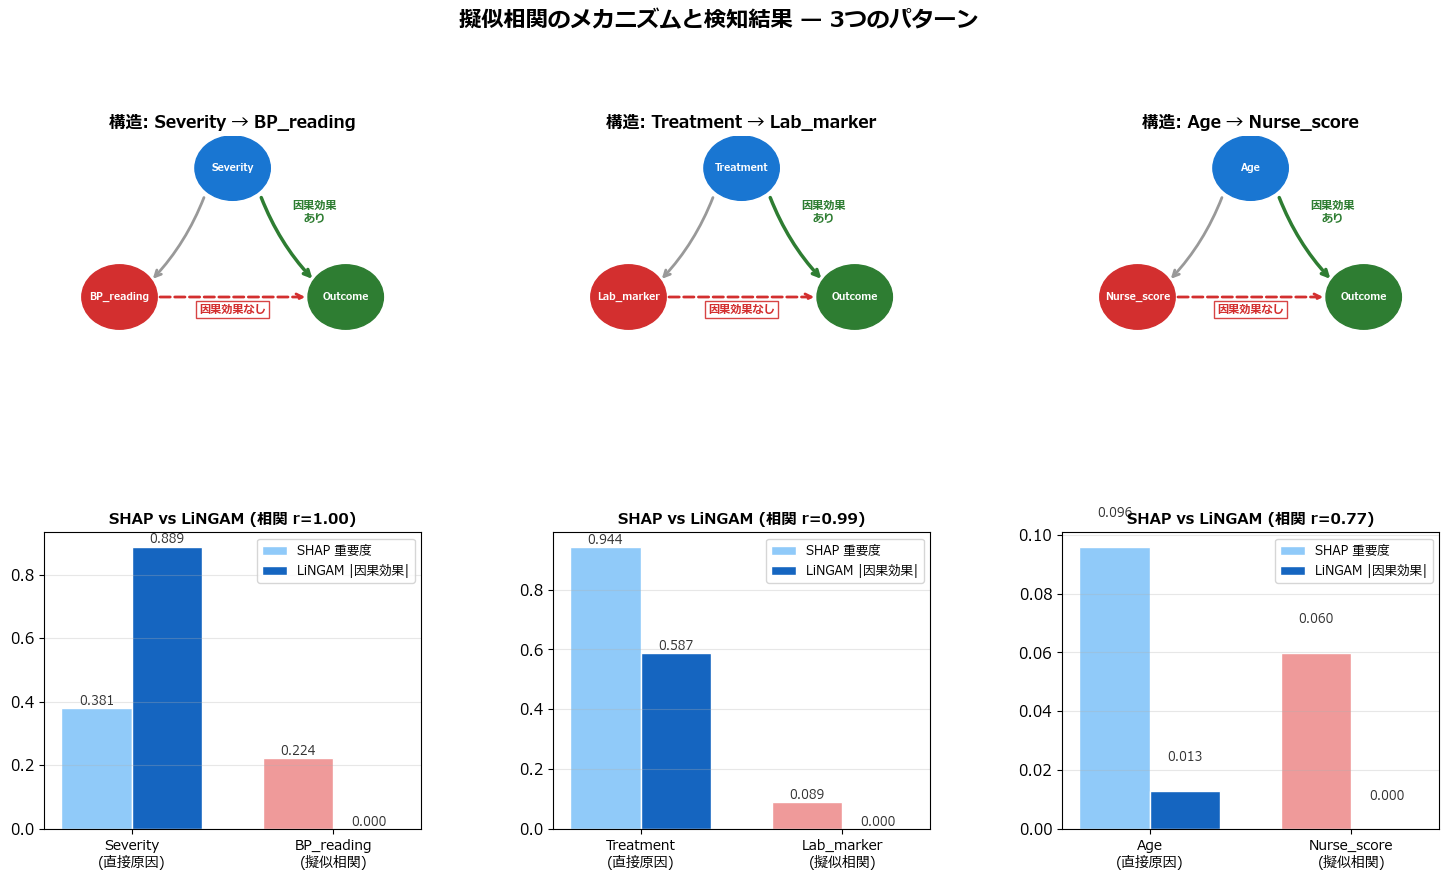

上段: 直接原因から擬似相関変数が生成される構造 (子ノード)
下段: SHAP は親子両方に重要度を付与、LiNGAM は子の因果効果を ≈0 と正しく推定


In [7]:
spurious_parents = {
    'BP_reading': 'Severity',
    'Lab_marker': 'Treatment',
    'Nurse_score': 'Age',
}

fig = plt.figure(figsize=(18, 9))
gs = GridSpec(2, 3, figure=fig, hspace=0.55, wspace=0.35,
              height_ratios=[1, 1.2])

for idx, (spurious, parent) in enumerate(spurious_parents.items()):
    # --- 上段: ミニ DAG ---
    ax_dag = fig.add_subplot(gs[0, idx])
    ax_dag.set_xlim(-1.5, 1.5)
    ax_dag.set_ylim(-0.8, 1.5)
    ax_dag.axis('off')

    # ノード位置
    dag_pos = {
        parent: (0, 1.2),
        spurious: (-0.9, 0),
        'Outcome': (0.9, 0),
    }

    # ノード描画
    for name, (x, y) in dag_pos.items():
        if name == parent:
            color = CAT_COLORS['直接原因']
        elif name == 'Outcome':
            color = '#2E7D32'
        else:
            color = CAT_COLORS['擬似相関']
        circle = plt.Circle((x, y), 0.3, color=color, zorder=3)
        ax_dag.add_patch(circle)
        ax_dag.text(x, y, name, ha='center', va='center',
                   fontsize=7, fontweight='bold', color='white', zorder=4)

    # 矢印: 親 → Outcome (因果効果あり)
    ax_dag.annotate('', xy=(0.65, 0.15), xytext=(0.22, 0.95),
                   arrowprops=dict(arrowstyle='->', color='#2E7D32',
                                  lw=2.5, connectionstyle='arc3,rad=0.1'))
    ax_dag.text(0.65, 0.7, '因果効果\nあり', fontsize=8, color='#2E7D32',
              fontweight='bold', ha='center')

    # 矢印: 親 → 子 (構造のみ)
    ax_dag.annotate('', xy=(-0.65, 0.15), xytext=(-0.22, 0.95),
                   arrowprops=dict(arrowstyle='->', color='#999',
                                  lw=2, connectionstyle='arc3,rad=-0.1'))

    # バツ印: 子 → Outcome (因果効果なし)
    ax_dag.annotate('', xy=(0.6, 0), xytext=(-0.6, 0),
                   arrowprops=dict(arrowstyle='->', color='#D32F2F',
                                  lw=2, linestyle='dashed'))
    ax_dag.text(0, -0.15, '因果効果なし', fontsize=8, color='#D32F2F',
              fontweight='bold', ha='center',
              bbox=dict(facecolor='white', edgecolor='#D32F2F', pad=2, alpha=0.9))

    ax_dag.set_title(f'構造: {parent} → {spurious}',
                    fontsize=12, fontweight='bold')

    # --- 下段: SHAP vs LiNGAM 対比棒グラフ ---
    ax_bar = fig.add_subplot(gs[1, idx])

    corr = df[parent].corr(df[spurious])
    shap_parent = shap_importance[parent]
    shap_child = shap_importance[spurious]
    lingam_parent_eff = abs(lingam_effects[parent])
    lingam_child_eff = abs(lingam_effects[spurious])

    x_labels = [f'{parent}\n(直接原因)', f'{spurious}\n(擬似相関)']
    x_pos = np.arange(2)
    w = 0.35

    # SHAP (正規化して比較しやすく)
    shap_max = max(shap_parent, shap_child, lingam_parent_eff, lingam_child_eff)
    bars_shap = ax_bar.bar(x_pos - w/2, [shap_parent, shap_child], w,
                          color=['#90CAF9', '#EF9A9A'], edgecolor='white',
                          label='SHAP 重要度')
    bars_lingam = ax_bar.bar(x_pos + w/2, [lingam_parent_eff, lingam_child_eff], w,
                           color=['#1565C0', '#C62828'], edgecolor='white',
                           label='LiNGAM |因果効果|')

    # 値ラベル
    for bar in bars_shap:
        h = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2, h + 0.01,
                   f'{h:.3f}', ha='center', fontsize=9, color='#333')
    for bar in bars_lingam:
        h = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2, h + 0.01,
                   f'{h:.3f}', ha='center', fontsize=9, color='#333')

    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(x_labels, fontsize=10)
    ax_bar.set_title(f'SHAP vs LiNGAM (相関 r={corr:.2f})',
                    fontsize=11, fontweight='bold')
    ax_bar.legend(fontsize=9, loc='upper right')
    ax_bar.grid(axis='y', alpha=0.3)

fig.suptitle('擬似相関のメカニズムと検知結果 — 3つのパターン',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('上段: 直接原因から擬似相関変数が生成される構造 (子ノード)')
print('下段: SHAP は親子両方に重要度を付与、LiNGAM は子の因果効果を ≈0 と正しく推定')

---
## 5. 介入シミュレーション — 擬似相関に基づく介入は効果なし

SHAP が「重要」と判定した擬似相関変数に対して介入しても Outcome は変化しません。  
一方、LiNGAM が「直接原因」と判定した変数に介入すると Outcome が変化します。

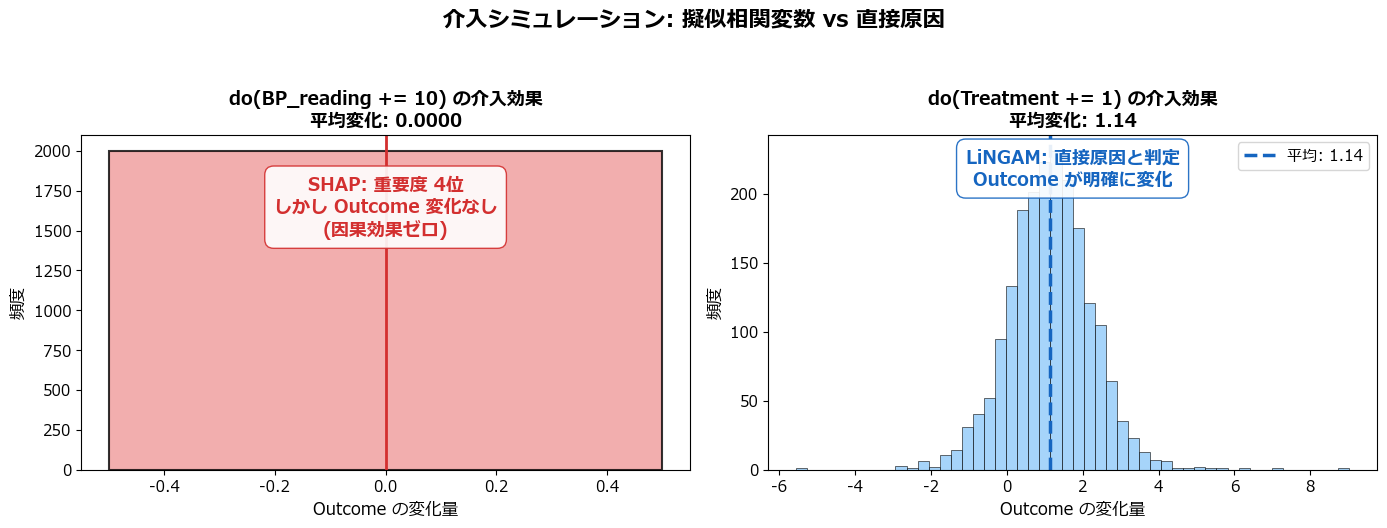

擬似相関 (BP_reading) を操作: Outcome 変化 = 0.0000 → 効果なし
直接原因 (Treatment) を +1:   Outcome 変化 = 1.14 → 明確な効果

→ SHAP が重要と判定した擬似相関変数に基づいて介入しても、効果は得られない
→ LiNGAM が特定した直接原因に介入すれば、Outcome を改善できる


In [8]:
import sys
sys.path.insert(0, '..')
from generate_dataset_valid import generate_data

# 同一シードでベースラインデータ生成
df_base = generate_data(n=2000, seed=999)
outcome_base = df_base['Outcome'].values

# 介入: Treatment を +1 すると Outcome は変化する
rng = np.random.default_rng(999)
treatment_shifted = df_base['Treatment'].values + 1
drugb_shifted = 0.8 * treatment_shifted + rng.normal(0, 0.4, 2000)
outcome_do_treat = (0.6 * treatment_shifted + 0.9 * df_base['Severity'].values
                    + 0.5 * (df_base['Age'].values / 50)
                    + 0.7 * drugb_shifted + rng.normal(0, 0.6, 2000))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('介入シミュレーション: 擬似相関変数 vs 直接原因',
             fontsize=16, fontweight='bold', y=1.05)

# 左: do(BP_reading) — 変化なし (SHAP が重要と判定した擬似相関変数)
diff_bp = np.zeros(2000)
axes[0].hist(diff_bp, bins=1, color='#EF9A9A', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].axvline(x=0, color='#D32F2F', linewidth=2)
axes[0].set_title(f'do(BP_reading += 10) の介入効果\n平均変化: {diff_bp.mean():.4f}',
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Outcome の変化量')
axes[0].set_ylabel('頻度')
axes[0].text(0.5, 0.7, 'SHAP: 重要度 4位\nしかし Outcome 変化なし\n(因果効果ゼロ)',
            transform=axes[0].transAxes,
            ha='center', fontsize=13, fontweight='bold', color='#D32F2F',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                     edgecolor='#D32F2F', alpha=0.9))

# 右: do(Treatment+1) — 変化あり (LiNGAM が直接原因と判定)
diff_treat = outcome_do_treat - outcome_base
axes[1].hist(diff_treat, bins=50, color='#90CAF9', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1].axvline(x=diff_treat.mean(), color='#1565C0', linewidth=2.5, linestyle='--',
                label=f'平均: {diff_treat.mean():.2f}')
axes[1].set_title(f'do(Treatment += 1) の介入効果\n平均変化: {diff_treat.mean():.2f}',
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Outcome の変化量')
axes[1].set_ylabel('頻度')
axes[1].legend(fontsize=11)
axes[1].text(0.5, 0.85, 'LiNGAM: 直接原因と判定\nOutcome が明確に変化',
            transform=axes[1].transAxes,
            ha='center', fontsize=13, fontweight='bold', color='#1565C0',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                     edgecolor='#1565C0', alpha=0.9))

plt.tight_layout()
plt.show()

print(f'擬似相関 (BP_reading) を操作: Outcome 変化 = {diff_bp.mean():.4f} → 効果なし')
print(f'直接原因 (Treatment) を +1:   Outcome 変化 = {diff_treat.mean():.2f} → 明確な効果')
print('\n→ SHAP が重要と判定した擬似相関変数に基づいて介入しても、効果は得られない')
print('→ LiNGAM が特定した直接原因に介入すれば、Outcome を改善できる')

---
## 6. サマリ — エグゼクティブ向け

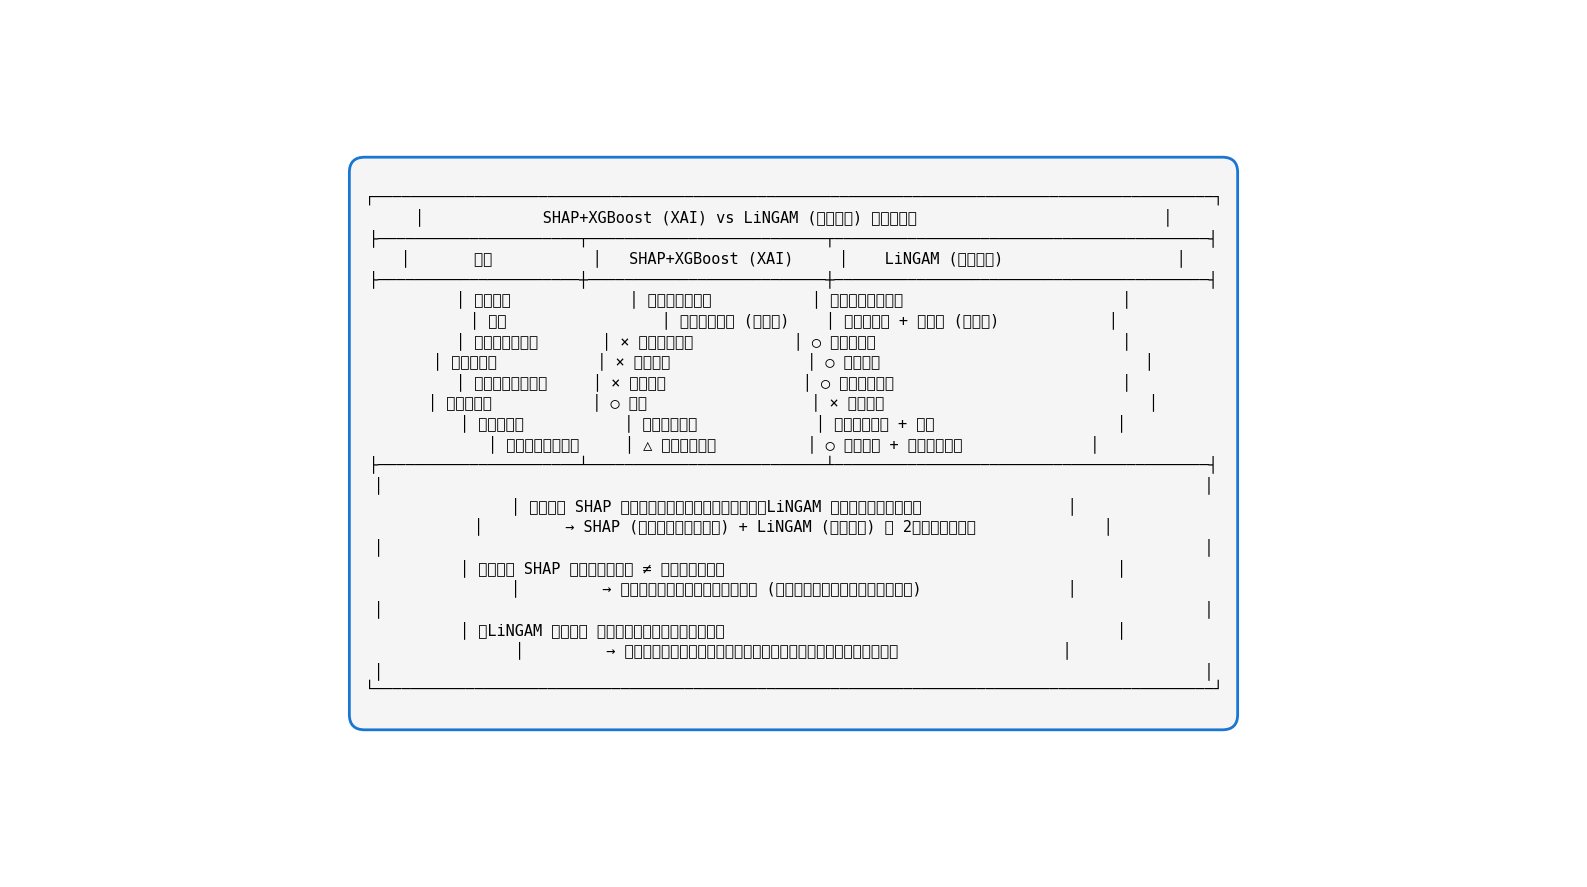

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.axis('off')

summary_text = """                                                                          
┌────────────────────────────────────────────────────────────────────────────────────────────┐
│             SHAP+XGBoost (XAI) vs LiNGAM (因果探索) 比較サマリ                           │
├──────────────────────┬──────────────────────────┬─────────────────────────────────────────┤
│       項目           │   SHAP+XGBoost (XAI)     │    LiNGAM (因果探索)                   │
├──────────────────────┼──────────────────────────┼─────────────────────────────────────────┤
│ 測定対象             │ 予測への貢献度           │ 因果効果の大きさ                        │
│ 出力                 │ 重要度スコア (連続値)    │ 因果グラフ + 効果量 (連続値)            │
│ 擬似相関の識別       │ × 識別できない           │ ○ 正しく除外                           │
│ 因果の方向           │ × 判定不可               │ ○ 推定可能                             │
│ 因果効果の大きさ     │ × 出力なし               │ ○ 連続値で出力                         │
│ 非線形対応           │ ○ 対応                  │ × 線形のみ                             │
│ 必要な仮定           │ モデルに依存             │ 非ガウス誤差 + 線形                    │
│ 意思決定への適用     │ △ 予測目的のみ          │ ○ 構造同定 + 介入効果推定              │
├──────────────────────┴──────────────────────────┴─────────────────────────────────────────┤
│                                                                                          │
│ 【推奨】 SHAP で重要と判定された変数に対して、LiNGAM で因果構造を検証する                │
│         → SHAP (候補スクリーニング) + LiNGAM (因果検証) の 2段階アプローチ              │
│                                                                                          │
│ 【注意】 SHAP の重要度が高い ≠ 因果効果がある                                           │
│         → 擬似相関変数への介入は効果なし (介入シミュレーションで実証済み)                │
│                                                                                          │
│ 【LiNGAM の強み】 因果効果の大きさまで推定可能                                           │
│         → どの変数にどれだけ介入すべきかの優先順位付けに直接活用できる                  │
│                                                                                          │
└────────────────────────────────────────────────────────────────────────────────────────────┘
"""

ax.text(0.5, 0.5, summary_text, transform=ax.transAxes,
        fontsize=11, fontfamily='monospace', verticalalignment='center',
        horizontalalignment='center',
        bbox=dict(boxstyle='round,pad=1', facecolor='#F5F5F5',
                  edgecolor='#1976D2', linewidth=2))

plt.tight_layout()
plt.show()

---

### 補足: 本レポートの技術的前提

| 項目 | 内容 |
|:---|:---|
| データ | 医療ドメインの合成データ (1,500行, 14変数) |
| 真の因果構造 | 既知 (17エッジの DAG) |
| 分布設計 | 非ガウス分布 (t分布, Gamma, LogNormal, Beta, 混合正規, Exponential) |
| SHAP モデル | XGBoost (300本, max_depth=6, lr=0.1) + TreeExplainer |
| 因果探索 | DirectLiNGAM, 隣接判定閾値=0.1 |
| 目的変数 | Outcome (治療成果) |
| 直接原因 | Treatment, Severity, Age, DrugB (4変数) |
| 擬似相関 | BP_reading, Lab_marker, Nurse_score (3変数) |